# Funathon 2023 - Sujet 5

Responsables :
- Antoine Palazzolo, SSP Lab
- Romain Avouac, DIIT

# Analyse textuelle des commentaires clients de services de commande de repas en ligne

## Avant de commencer...

Ce sujet, disponible uniquement en Python, porte sur deux thématiques principales :
- Le web scraping
- Le NLP

Les deux parties sont indépendantes l'une de l'autre, il est donc possible de n'en faire qu'une des deux.

Si jamais vous n'êtes pas familiers avec l'un de ces sujets (ou les deux), nous ne saurions que trop vous recommander de jeter un oeil aux ressources suivantes :
- Débuter en web scraping : https://pythonds.linogaliana.fr/webscraping/
- Web scraping et bonnes pratiques : https://github.com/InseeFrLab/formation-webscraping
- Débuter en NLP : https://pythonds.linogaliana.fr/course/nlp/

Exécutez la cellule ci-dessous pour installer les packages nécessaires au sujet :

In [ ]:
!pip install --quiet -r requirements.txt

## Partie 1 : Scraping d'avis sur Trustpilot

Pour pouvoir faire de l'analyse textuelle de commentaires clients, la première chose dont nous avons besoin c'est justement d'une base d'avis et de commentaires.
Vous pourrez trouver de tels avis sur à peu près n'importe quel site de vente en ligne ou bien sur un certain nombre de comparateurs.
En revanche, comment récupérer l'information depuis une page Internet pour nous constituer un jeu de données sur lequel travailler ?

Eh bien c'est justement là qu'intervient le web scraping, qui permet de collecter automatiquement de l'information d'un site web, que ce soit du texte, des images, des tableaux, sans avoir à parcourir toutes les pages soi-même en faisant un copier-coller à la main du contenu.
Le web scraping est donc un outil très puissant, mais à utiliser avec des pincettes.
Cela doit plutôt être vu comme un dernier recours, lorsqu'il n'est pas possible d'accéder aux données plus facilement.

En effet, de nombreuses contraintes juridiques encadrent par exemple le webscraping, il n'est pas possible de faire ce que l'on veut.
Qui plus est, de plus en plus de sites apprennent à se défendre contre cette collecte automatique de leurs données, rendant la tâche plus difficile.
Pour en savoir plus sur ces thématiques, n'hésitez pas à consulter cette formation : https://inseefrlab.github.io/formation-webscraping/.

<br>

Les données mises à disposition pour ce sujet ont été extraites du site https://fr.trustpilot.com/.
Votre première tâche va être de créer votre propre scraper pour pouvoir recréer une base similaire.

Afin de ne pas surcharger le traffic du site, nous n'allons pas vous demander d'en scraper l'intégralité.
Vous allez donc vous limiter à une entreprise de votre choix parmi celles de la catégorie _takeaway_ : https://fr.trustpilot.com/categories/takeaway.
Cliquez sur le lien et promenez-vous sur le site.

### 1. Bien préparer son scraping : découvrir le site ciblé

La première chose à faire pour tout bon adepte de scraping, c'est apprendre à connaître la page web cible :
- A quoi ressemble l'url du site ? Y a-t-il un radical commun lorsque l'on passe d'une page à une autre ? Par exemple ici lorsque l'on change d'entreprise comparée ou que l'on va chercher les avis les plus reculés ?
- Quelles sont les informations disponibles sur la page ? Y a-t-il besoin de cliquer sur un bouton pour les faire apparaître ?
- Les différentes pages que je souhaite scraper ont-elles bien des formats similaires ? La construction des pages change-t-elle d'une entreprise comparée à une autre ?

<br>

Il faut ensuite aller un peu plus loin dans l'analyse et regarder la structure HTML de la page ciblée.
Si vous n'êtes pas familiers avec cette partie, n'hésitez pas à consulter les ressources précédemment citées.

Tout d'abord, choisissez l'entreprise dont vous allez extraire les commentaires et cliquez sur sa page Trustpilot.
A présent, après un clic droit sur un élément de la page, il suffit de cliquer sur "Inspecter l'élément" pour naviguer dans l'architecture de la page et analyser le positionnement de l'élément sélectionné.
Cliquez sur divers éléments de la page pour vous familiariser avec sa structure.
- Comment sont rangés les commentaires ? Comprenez-vous bien l'arborescence de la page ?
- Regardez les balises autour de chaque note, y a-t-il un pattern ou un élément commun qui permet de les identifier et les distinguer des autres ?

### 2. Premiers pas : récupérer l'information du nombre de pages

#### Variables globales

In [ ]:
radical_trustpilot = '' # TODO
company = '' # TODO

url_company = radical_trustpilot + company

Maintenant que vous avez votre premier lien à scraper, il va falloir envoyer une __requête__ au site pour demander à en récupérer le contenu, sous le format HTML.
C'est sur le contenu retourné que nous travaillerons ensuite.

En Python, un package permet facilement de faire ces requêtes, il s'agit de _requests_, et plus précisément de la fonction ```requests.get()```, qui prend en argument l'url ciblé.
En plus du lien à requêter, la fonction peut prendre d'autres arguments, appelés __headers__, comme _User_Agent_ ou _From_ qui permettent de s'identifier lors de la requête envoyée au site.

Pourquoi s'identifier me demanderez-vous ? Eh bien tout d'abord parce qu'il s'agit là d'une bonne pratique de scraping.
Les sites reçoivent parfois énormément de requêtes sur leurs pages, par exemple à cause de scrapers trop gourmands, et cela peut leur créer des problèmes.
Ils peuvent donc être amenés à par exemple bloquer les adresses IP des utilisateurs jugés abusifs.
S'identifier clairement dans ses requêtes, en explicitant le but de la collecte, permet de faire preuve de transparence.
Même si en pratique cela n'arrive que très peu, cela laisse alors la possibilité au propriétaire du site de contacter le scraper afin d'avoir plus d'informations sur le but de la collecte, et possiblement offrir l'accès aux données sans scraping.

Une autre bonne pratique pour ne pas être trop agressif vis-à-vis du site scrapé est d'étaler ses requêtes dans le temps, par exemple en forçant votre code à prendre une pause d'au moins 3 secondes entre chaque requête effectuée si vous visitez plusieurs pages.

Ici, complétez les headers ci-dessous avec vos informations pour faire preuve de transparence auprès de Trustpilot :

In [ ]:
headers = {
    'User-Agent': '', # Nom, entité, but de la collecte, informations pertinentes
    'From': '' # Coordonnées à laisser au propriétaire du site en cas de besoin
}

Nous réutiliserons ces headers dans toutes les requêtes du sujet.

#### Créer sa première requête

In [ ]:
import requests
import time

Utilisez la fonction ```requests.get()``` et vos headers pour requêter votre site, puis utilisez la méthode ```.text``` pour récupérer le contenu HTML de la page désirée sous forme de texte.

Vous pouvez aussi déjà prendre le réflexe d'ajouter un ```time.sleep(3)``` à l'issue de chaque requête effectuée pour ne pas surcharger le site lorsque nous aurons davantage de requêts à faire.

In [ ]:
request_text = '' # TODO

print(request_text)

Si vous avez bien fait les choses, vous devriez maintenant avoir quelque chose d'assez illisible, c'est normal.
Il va maintenant falloir faire appel à un autre package pour __parser__ cette chaîne de caractères en une arborescence plus exploitable.

#### Parsing d'un document HTML : BeautifulSoup

La fonction ```BeautifulSoup()```, du package du même nom, est ce qui va nous permettre de faire ce parsing.
Rien de tel que l'essayer sur notre texte pour voir quel est son effet :

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
soup = '' # TODO

print(soup)

Normalement ça a déjà une meilleure tête !
On dira que le contenu HTML est désormais sous la forme d'une _soupe_.
L'idée maintenant va être de naviguer parmi l'arborescence des balises dans cette _soupe_ pour aller chercher l'information que l'on souhaite.

#### Chercher un élément dans l'arborescence

Deux méthodes sont particulièrement utiles lorsque l'on travaille avec BeautifulSoup :

- ```soup.find(type_de_balise, {'class': classe_de_la_balise)```, pour trouver le premier le premier élément correspondant à la recherche effectuée
    + La méthode ```.text``` permet ensuite d'en extraire le contenu textuel affiché sur le site
- ```soup.find_all(type_de_balise, {'class': classe_de_la_balise)```, pour renvoyer la liste de tous les éléments correspondant à la recherche effectuée

Les types de balise sont souvent assez standards : ```div```, ```a```, ```span```.
Quant aux noms de classes, ils ne sont pas toujours très explicites, mais que cela ne vous décourage pas !

Pour commencer, entraînez-vous à manipuler ces deux fonctions en récupérant des informations diverses sur le site. Vous pouvez également imbriquer plusieurs de ces fonctions les unes après les autres, l'output d'une recherche pouvant être une plus petite _soupe_ pour donnée en input d'une nouvelle recherche.

Quand vous êtes prêts, utilisez les méthodes ci-dessus pour associer à la variable ```nb_pages``` le nombre de pages d'avis pour l'entreprise considérée.

In [ ]:
nb_pages = 0  # TODO

Indice : Le nombre de pages est accessible au bas de la page. En revanche, la balise contenant l'information et son nom de classe ne sont peut-être pas uniques...

#### Mise sous fonction (et corrigé)

Maintenant que vous avez compris le principe, il est temps de regrouper tout ce qui a été fait en une fonction ```get_nb_pages_review()``` prenant en entrée un cible et renvoyant le nombre de pages d'avis.
Attention cette fois à rajouter une condition d'exception si jamais aucune balise du type désirée n'est trouvée...

In [ ]:
def get_nb_pages_reviews(url_company):

    # TODO
    
    return 0

In [ ]:
url_test_1 = radical_trustpilot + "deligreens.com"
get_nb_pages_reviews(url_test_1)

In [ ]:
url_test_2 = radical_trustpilot + "entreprise_mystere.com"  # Entreprise qui n'existe pas
get_nb_pages_reviews(url_test_2)  # Doit pouvoir s'exécuter sans erreur

<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_nb_pages_reviews(url_company):

    time.sleep(3)
    request_text = requests.get(url_company, headers=headers).text
    soup = BeautifulSoup(request_text, 'html.parser')

    try:
        boutons_pages = soup.find(
            'div', {'class':'styles_pagination__6VmQv'}
        ).find_all(
            'span', {'class':'typography_heading-xxs__QKBS8 typography_appearance-inherit__D7XqR typography_disableResponsiveSizing__OuNP7'}
        )
        last_page = int(boutons_pages[-2].text)  # Dernier bouton = "Page Suivante"
        return last_page

    except:
        return 0
```

</details>


### 3. Mise en pratique : récupérer les avis d'une entreprise

#### Récupérer les informations au sein d'une review donnée

In [ ]:
import re

from datetime import datetime

Imaginez que vous avez sous la main le code HTML (sous forme de _soupe_) relatif à une seule review sur votre page (vous pouvez voir en inspectant la page que chaque review est contenue dans une balise ```div``` distincte, les unes après les autres).

Nous allons maintenant tâcher de récupérer les informations relatives à une review à l'aide de la méthode ```.find()```. Complétez les fonctions ci-dessous, sans oublier de rattraper les exceptions s'il y a un problème quelconque avec votre review d'entrée.

Attention, les fonctions ci-dessous demandent parfois de récupérer autre chose que du texte, il faudra donc réfléchir à des alternatives à la méthode ```.text```.

In [ ]:
def get_note_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        note: Note de l'avis (entier entre 1 et 5)
    """

    # TODO
    
    return 0

Indices :
- Pour récupérer un texte dans une balise _img_, un argument supplémentaire peut être passé à la fonction ```.find()```,  il s'agit de ```alt=True```
- Penser à convertir le texte récupéré en une note sous la forme d'entier

<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_note_review(review):
    
    try:
        texte_note = review.find(
            'div', {'class':'star-rating_starRating__4rrcf star-rating_medium__iN6Ty'}
        ).find('img', alt=True)['alt']
        note = int(texte_note[5])  # texte_note = "Noté x étoiles sur 5"
        return note

    except:
        return "Not found"
```

</details>

In [ ]:
def get_time_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        date: Date et heure de l'avis (datetime)
    """

    # TODO
    
    return 0



Indice : La fonction ```datetime.strptime()``` permet de convertir la chaîne de caractères récupérée en un format date.

<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_time_review(review):
    
    try:
        str_date = review.find(
            'div', {'class':'typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_datesWrapper__RCEKH'}
        ).find('time')['datetime']
        date = datetime.strptime(str_date, "%Y-%m-%dT%H:%M:%S.%fZ")  # str_date = 'YYYY-MM-DDThh:mm:ss.000Z'
        return date

    except:
        return "Not found"
```

</details>

In [ ]:
def get_title_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        title: Titre de la review (str)
    """

    # TODO
    
    return ''



<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_title_review(review):
    
    try:
        title = review.find(
            'h2', {'class':'typography_heading-s__f7029 typography_appearance-default__AAY17'}
        ).text
        return title

    except:
        return "Not found"
```

</details>

In [ ]:
def get_comment_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        comment: Commentaire associé à la review (str)
    """

    # TODO
    
    return ''



<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def get_comment_review(review):
    
    try:
        text = review.find(
            'p', {'class':'typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn'}
        ).text # Les balises <br> sont supprimées, on va donc forcer des espaces après les points
        text = re.sub(' +', ' ', text.replace('.', '. '))
        return text

    except:
        return "Not found"
```

</details>

#### Scraper toutes les reviews d'une entreprise

Nous sommes désormais capables de récupérer toutes les informations contenues dans une review donnée.
Reste maintenant à itérer sur l'ensemble des reviews d'une page, puis sur l'ensemble des pages (limité à 5 pages pour ne pas surcharger le site cible).

Complétez la fonction ci-dessous pour récupérer l'ensemble des informations extraites des reviews en un dataframe aisément manipulable.

Attention : bien penser à ajouter des pauses entre chaque requête d'au moins 3 secondes à l'aide de la commande ```time.sleep(3)```

In [ ]:
import pandas as pd

from tqdm import tqdm

In [ ]:
def scraping_one_company(url_company, limit_pages=True):

    nb_pages = get_nb_pages_reviews(url_company)
    if limit_pages and nb_pages > 5:
        nb_pages = 5
    notes, times, titles, comments = [], [], [], []

    for page in tqdm(range(1, nb_pages+1)):

        # TODO

    df_reviews = pd.DataFrame({
        'note': notes,
        'date': times,
        'title': titles,
        'comment': comments
    })

    return df_reviews

Indices :
- Quel va être l'url à requêter pour chaque page ?
- Souvenez-vous de la fonction ```.find_all()```

<details>
<summary> Dérouler pour révéler le corrigé</summary>
<br>

```{python}
def scraping_one_company(url_company, limit_pages=True):

    nb_pages = get_nb_pages_reviews(url_company)
    if limit_pages and nb_pages > 5:
        nb_pages = 5
    notes, times, titles, comments = [], [], [], []

    for page in tqdm(range(1, nb_pages+1)):

        time.sleep(3)
        url_page = url_company + '?page=' + str(page)
        
        try:
            request_text = requests.get(url_page, headers=headers).text
            soup = BeautifulSoup(request_text, 'html.parser')
            reviews = soup.find_all(
                'div', {'class':'styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ'}
            )
        except:
            reviews = []

        notes.extend(list(map(get_note_review, reviews)))
        times.extend(list(map(get_time_review, reviews)))
        titles.extend(list(map(get_title_review, reviews)))
        comments.extend(list(map(get_comment_review, reviews)))

    df_reviews = pd.DataFrame({
        'note': notes,
        'date': times,
        'title': titles,
        'comment': comments
    })

    return df_reviews
```

</details>

### 4. Collecte et vérification des résultats

Maintenant nos fonctions codées, il ne reste plus qu'à mettre en pratique et récupérer nos avis !

In [ ]:
df_reviews = scraping_one_company(url_company, limit_pages=True)

df_reviews

Lorsque l'on scrape des données sur Internet, la qualité attendue n'est pas toujours au rendez-vous.
Il convient donc de bien vérifier ce qui est obtenu en sortie pour ne pas avoir de mauvaises surprises.
Prenez un moment pour analyser vos données de sortie :

- Le format des colonnes est-il bon ? Les textes ont-ils tous bien une apparence lisible ?
- Y a-t-il des NaNs dans certaines colonnes ? Autrement dit des informations possiblement manquantes pour certaines reviews sur le site ?
- Avez-vous bien le nombre de lignes attendu en sortie ?

Pourquoi ne pas faire quelques visualisations avec matplotlib pour regarder à quoi ressemblent les distributions de nos variables ?

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Amusez-vous ici avec df_reviews


La partie scraping est à présent terminée.
La table que vous trouverez pour la seconde partie du sujet a été obtenue par scraping en itérant ce que vous avez recodé sur une liste donnée d'entreprises.

Si vous souhaitez en savoir plus sur le monde du web scraping ou si vous voulez réitérer l'expérience sur d'autres sites, n'hésitez pas à consulter les ressources mentionnées au début du sujet.

## Partie 2 : Analyse textuelle et NLP

### Import des données

In [178]:
import pandas as pd

In [179]:
df = pd.read_parquet("data/reviews_takeaway.parquet")

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20438 entries, 0 to 20437
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   note     20438 non-null  int64         
 1   date     20438 non-null  datetime64[ns]
 2   title    20438 non-null  object        
 3   comment  20438 non-null  object        
 4   company  20438 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 798.5+ KB


### Analyse descriptive

In [67]:
import re

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

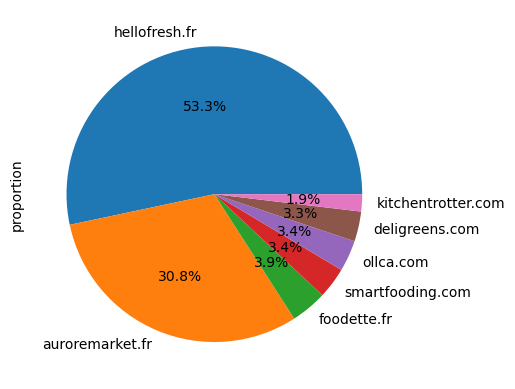

In [68]:
# Pourcentage d'avis en fonction de l'entreprise concernée
df["company"].value_counts(normalize=True).plot.pie(autopct="%.1f%%")
plt.show()

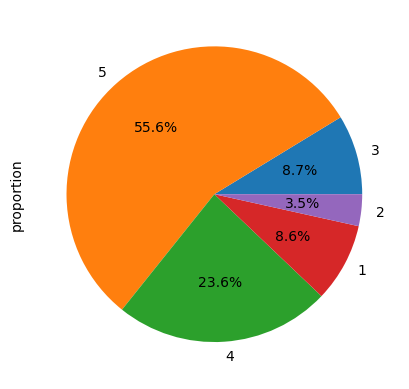

In [69]:
# Répartition des notes
df["note"].value_counts(normalize=True, sort=False).plot.pie(autopct="%.1f%%")
plt.show()

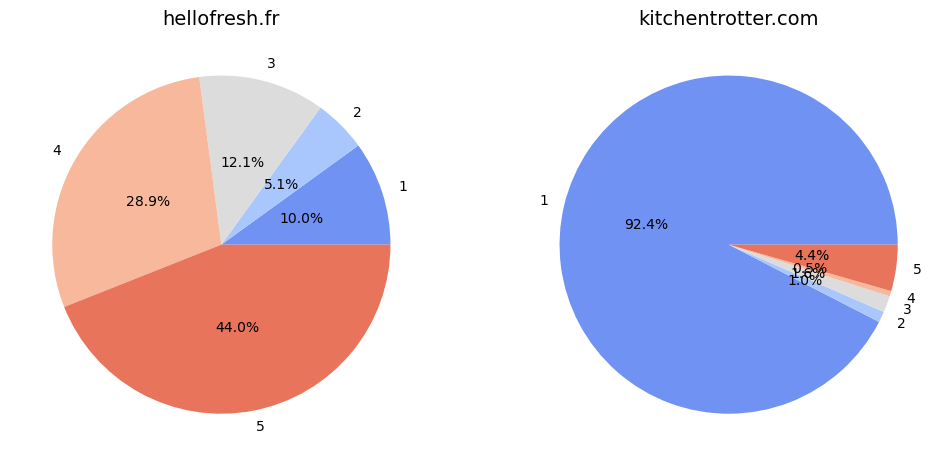

In [70]:
# Répartition des notes pour des entreprises données
plt.figure(figsize=[12,6])
plt.subplot(121)
colors = sns.color_palette('coolwarm', n_colors=5)
data = df[df['company'] == 'hellofresh.fr']["note"].value_counts(normalize=True, sort=False).sort_index()
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", labels=labels, colors = colors, pctdistance=0.5)
plt.title("hellofresh.fr", fontsize=14);

plt.subplot(122)
data = df[df['company'] == 'kitchentrotter.com']["note"].value_counts(normalize=True, sort=False).sort_index()
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", labels=labels, colors = colors, pctdistance=0.5)
plt.title("kitchentrotter.com", fontsize=14)

plt.show()

<Axes: xlabel='note', ylabel='comment_length'>

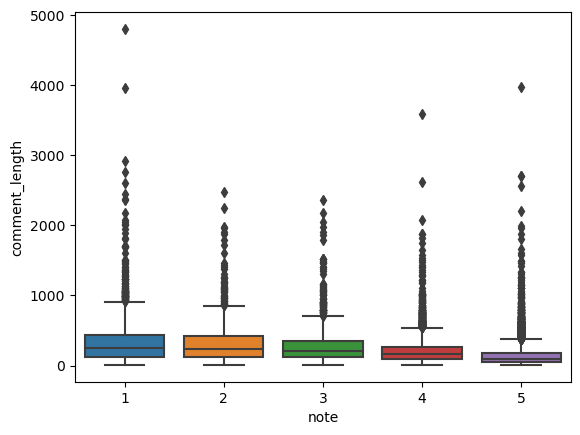

In [71]:
# Lien entre la longueur d'un commentaire et la note
df['comment_length'] = df['comment'].str.len()

fig, ax = plt.subplots()
sns.boxplot(x="note", y="comment_length", data=df, ax=ax)

In [72]:
# Regex pour extraire des infos du texte

def compte_majuscules(commentaire):
    r = re.compile(r"[A-Z]")
    capslock = r.findall(commentaire)
    return len(capslock) / len(commentaire)

def compte_points_exclamation(commentaire):
    r = re.compile(r"\!")
    exclamation = r.findall(commentaire)
    return len(exclamation) / len(commentaire)

df['part_majuscules'] = df['comment'].apply(compte_majuscules)
df['part_points_exclamation'] = df['comment'].apply(compte_points_exclamation)

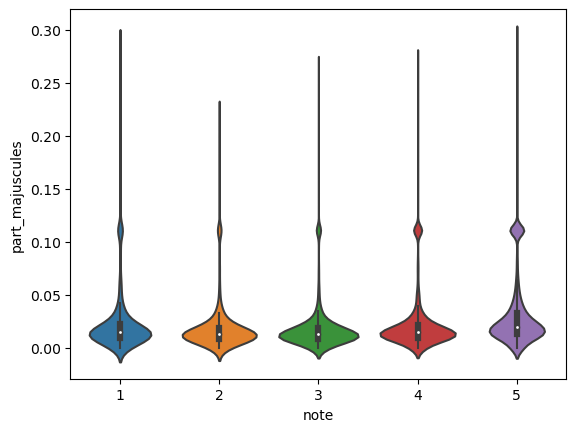

In [74]:
# Lien entre le nombre de majuscules et la note
data = df[df["part_majuscules"] < 0.3]
fig, ax = plt.subplots()
sns.violinplot(x="note", y="part_majuscules", data=data, ax=ax)
plt.show()

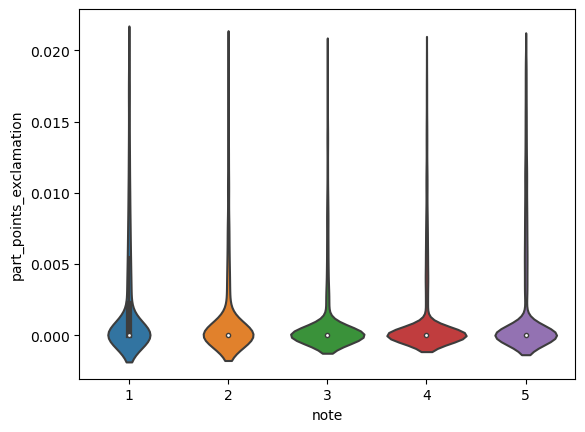

In [76]:
# Lien entre le nombre de points d'exclamation et la note
data = df[df["part_points_exclamation"] < 0.02]
fig, ax = plt.subplots()
sns.violinplot(x="note", y="part_points_exclamation", data=data, ax=ax)
plt.show()

TODO en exos : 
- nombre de points d'exclamation successifs
- nombre de points d'interrogation

### Nettoyage et prétraitements

In [77]:
import spacy 
from tqdm import tqdm

In [78]:
nlp = spacy.load("fr_core_news_sm")

In [79]:
comment = df["comment"].str.lower()[0]
doc = nlp(comment)

print(doc)

des produits manquants pour une recette, contact en chat, indemnisé de 4,05 euros sur l appli qui ne peut pas être utilisé en même temps qu une réduction donc sincèrement autant ne rien avoir, nous n avons pas toujours le budget donc je trouve ça vraiment décevant. au final c est soit on paye le prix fort, soit avec des parrainages donc ces 4,05 nous n en profiterons jamais. déçus


In [80]:
for token in doc[:15]:
    print(token.text, token.tag_)

des DET
produits NOUN
manquants ADJ
pour ADP
une DET
recette NOUN
, PUNCT
contact NOUN
en ADP
chat NOUN
, PUNCT
indemnisé ADJ
de ADP
4,05 NUM
euros NOUN


In [81]:
token = doc[0]
print(token, token.is_stop, token.is_punct, token.is_alpha)

token = doc[1]
print(token, token.is_stop, token.is_punct, token.is_alpha)

token = doc[6]
print(token, token.is_stop, token.is_punct, token.is_alpha)

token = doc[13]
print(token, token.is_stop, token.is_punct, token.is_alpha)

des True False True
produits False False True
, False True False
4,05 False False False


In [82]:
for token in doc[:15]:
    print(token.text, token.lemma_)

des un
produits produit
manquants manquant
pour pour
une un
recette recette
, ,
contact contact
en en
chat chat
, ,
indemnisé indemniser
de de
4,05 4,05
euros euro


In [83]:
no_stop_lemma_list = []

for token in doc:
    if not (token.is_stop or token.is_punct) and token.is_alpha and len(token) >= 3:
        no_stop_lemma_list.append(token.lemma_)

no_stop_lemma = " ".join(no_stop_lemma_list)

print(no_stop_lemma_list)
print()
print(no_stop_lemma)

['produit', 'manquant', 'recette', 'contact', 'chat', 'indemniser', 'euro', 'appli', 'utiliser', 'temps', 'réduction', 'sincèremer', 'autant', 'rien', 'budget', 'trouver', 'vraiment', 'décevant', 'final', 'payer', 'prix', 'fort', 'parrainage', 'profiteron', 'jamais', 'décevoir']

produit manquant recette contact chat indemniser euro appli utiliser temps réduction sincèremer autant rien budget trouver vraiment décevant final payer prix fort parrainage profiteron jamais décevoir


In [86]:
pipe = nlp.pipe(df["comment"].str.lower(), n_process=10,
                disable=["tagger", "parser", "attribute_ruler", "ner"])

In [87]:
def preprocess(token):
    if not (token.is_stop or token.is_punct) and token.is_alpha and len(token) >= 3:
        return token.lemma_
    else:
        return ""

commentaires_pretraites = []
for commentaire in tqdm(pipe):
    com_pretraite_list = [preprocess(token) for token in commentaire if token]
    com_pretraite = " ".join(com_pretraite_list)
    commentaires_pretraites.append(com_pretraite)

20438it [00:24, 849.09it/s] 


In [88]:
df["comment_pretraite"] = commentaires_pretraites
df[["title", "comment", "comment_pretraite"]].head()

,title,comment,comment_pretraite
0,Des produits manquants pour une…,"Des produits manquants pour une recette, conta...",produit manquant recette contact chat in...
1,Facile et pratique,Les box hellofresh nous facilitent le quotidie...,box hellofresh faciliter quotidien pense...
2,Super idée recettes délicieuses.,Super idée recettes délicieuses. Tous les ingr...,super idée recette délicieux ingrédient fo...
3,Service de livraison incompétent !,"Jusqu’à présent satisfait de la marque, mais u...",présent satisfait marque service livra...
4,Expérience d'achat inacceptable,Expérience d'achat inacceptable. Une chaîne du...,expérience achat inacceptable chaîne froid...


### Analyse fréquentiste des commentaires

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [177]:
ngram_range=(1,1)
texts = df["comment_pretraite"]

vectorizer = CountVectorizer(ngram_range=ngram_range)
vectorizer.fit(texts)

vocab = vectorizer.get_feature_names_out()
print(f"Taille du vocabulaire : {len(vocab)} ")

Taille du vocabulaire : 12873 


In [178]:
vectorizer.transform(texts)

<20438x12873 sparse matrix of type '<class 'numpy.int64'>'
	with 277062 stored elements in Compressed Sparse Row format>

In [179]:
comptages = np.array(vectorizer.transform(texts).sum(0))[0]
comptages_voc = list(zip(vocab, comptages))
comptages_voc = sorted(comptages_voc, key=lambda x: x[1], reverse=True)
comptages_voc = pd.DataFrame(comptages_voc, columns=['mot', 'frequence'])
comptages_voc.head()

,mot,frequence
0,produit,8564
1,recette,7941
2,bon,6913
3,livraison,6307
4,bien,4569


<Axes: xlabel='frequence', ylabel='mot'>

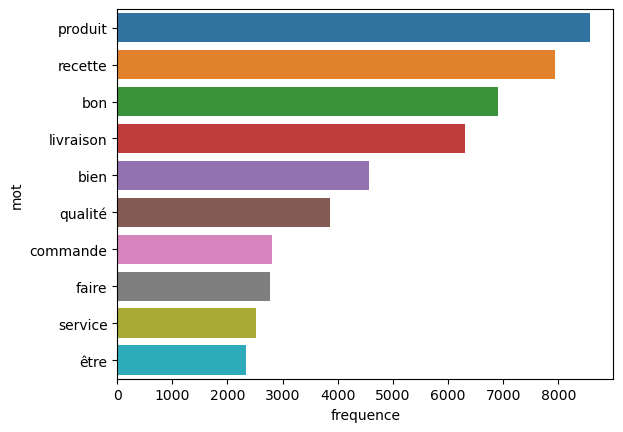

In [197]:
sns.barplot(x="frequence", y="mot", data=comptages_voc.head(10))

In [198]:
def plot_freq_n_grammes(commentaires, ngram_range=(1,1), n_results=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    vectorizer.fit(commentaires)
    vocab = vectorizer.get_feature_names_out()
    
    comptages = np.array(vectorizer.transform(commentaires).sum(0))[0]
    comptages_voc = list(zip(vocab, comptages))
    comptages_voc = sorted(comptages_voc, key=lambda x: x[1], reverse=True)
    comptages_voc = pd.DataFrame(comptages_voc, columns=['mot', 'frequence'])
    
    sns.barplot(x="frequence", y="mot", data=comptages_voc.head(n_results))
    
    return comptages_voc

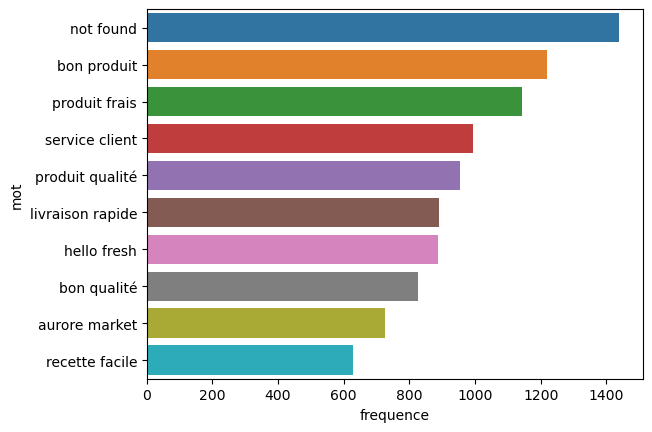

In [199]:
_ = plot_freq_n_grammes(commentaires=df["comment_pretraite"], 
                        ngram_range=(2,2), 
                        n_results=10)

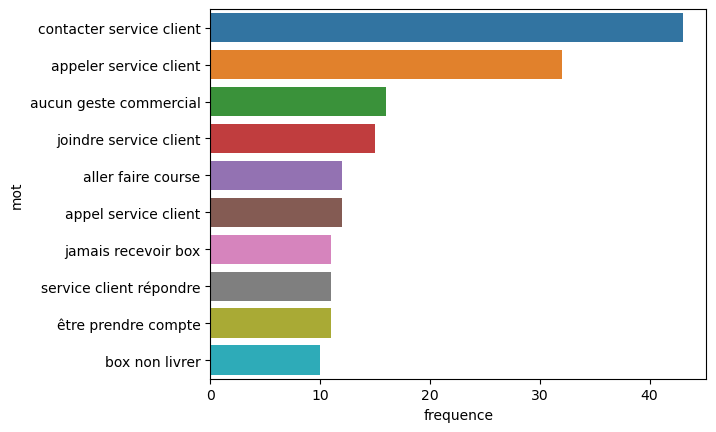

In [203]:
_ = plot_freq_n_grammes(commentaires=df[df["note"] == 1]["comment_pretraite"], 
                        ngram_range=(3,3), 
                        n_results=10)

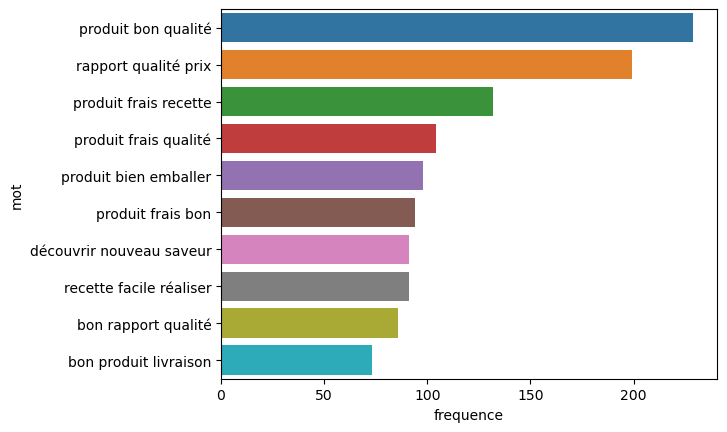

In [204]:
_ = plot_freq_n_grammes(commentaires=df[df["note"] == 5]["comment_pretraite"], 
                        ngram_range=(3,3), 
                        n_results=10)

### Apprentissage supervisé : prédiction de la note à partir du texte

In [215]:
from sklearn.model_selection import train_test_split

In [216]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [217]:
print(df_train.shape, df_test.shape)

(16350, 11) (4088, 11)


#### Approche "bag-of-words"

In [255]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVR

In [256]:
vectorizer = CountVectorizer(ngram_range=(1,3))

X_train = vectorizer.fit_transform(df_train["comment_pretraite"])
X_test = vectorizer.transform(df_test["comment_pretraite"])

voc = vectorizer.vocabulary_
print('Taille du vocabulaire : ', len(voc))

Taille du vocabulaire :  303275


In [257]:
y_train = df_train["note"]
y_test = df_test["note"]

In [258]:
svr = LinearSVR(max_iter=10000)

svr.fit(X_train, y_train)

LinearSVR(max_iter=10000)

In [259]:
y_pred = svr.predict(X_test)
y_pred

array([3.06758508, 1.79277718, 4.40131603, ..., 4.27669387, 4.38592516,
       4.53484406])

<Axes: xlabel='note', ylabel='note_predite'>

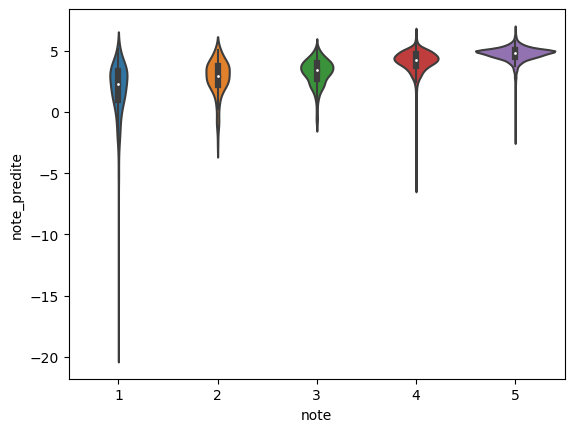

In [260]:
data = pd.DataFrame({'note': y_test, 'note_predite': y_pred})

sns.violinplot(x="note", y="note_predite", data=data)

<Axes: xlabel='note', ylabel='note_predite'>

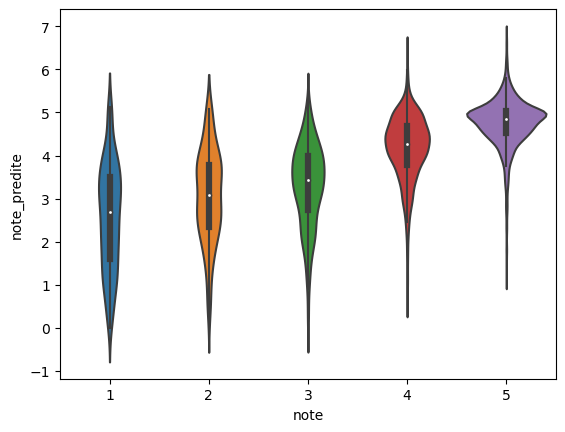

In [261]:
sns.violinplot(x="note", y="note_predite", data=data[data["note_predite"] >= 0])

#### Approche TF-IDF

In [262]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [263]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))

X_train = vectorizer.fit_transform(df_train["comment_pretraite"])
X_test = vectorizer.transform(df_test["comment_pretraite"])

In [264]:
svr = LinearSVR(max_iter=10000)

svr.fit(X_train, y_train)

LinearSVR(max_iter=10000)

In [265]:
y_pred = svr.predict(X_test)
y_pred

array([3.325885  , 0.40469364, 4.22689915, ..., 5.10501943, 5.10693282,
       4.91500702])

<Axes: xlabel='note', ylabel='note_predite'>

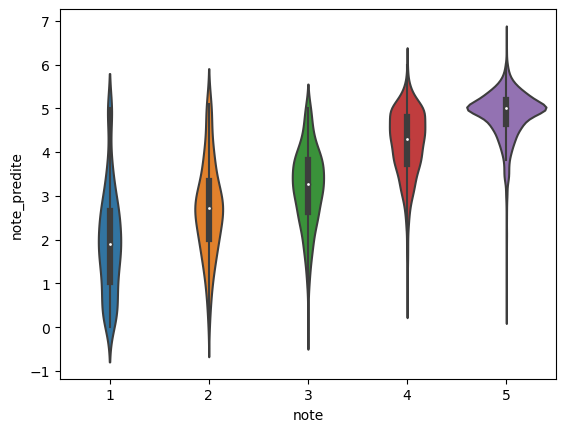

In [266]:
data = pd.DataFrame({'note': y_test, 'note_predite': y_pred})

sns.violinplot(x="note", y="note_predite", data=data[data["note_predite"] >= 0])

### Apprentissage non-supervisé : détection de sujets

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model

In [167]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, ngram_range=(1,3))
freq_matrix = vectorizer.fit_transform(df["comment_pretraite"])

In [168]:
lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(freq_matrix)

LatentDirichletAllocation(n_components=20, random_state=0)

In [169]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda, freq_matrix, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.190443  0.200684       1        1  12.269540
5     -0.123859 -0.195323       2        1  10.664569
18     0.192796  0.060732       3        1   8.563469
4      0.209940 -0.062070       4        1   6.076108
8      0.080087 -0.162990       5        1   5.699754
3      0.076485  0.144058       6        1   5.612362
9     -0.098103  0.047288       7        1   5.032368
14     0.224227 -0.032542       8        1   4.948605
7      0.035910  0.087886       9        1   4.715392
13     0.119828  0.045270      10        1   4.543779
2     -0.116677  0.177335      11        1   4.174046
16    -0.181188  0.041520      12        1   3.817077
19    -0.111715 -0.031766      13        1   3.669520
1      0.143103  0.025202      14        1   3.610841
0      0.137358 -0.014991      15        1   3.280417
10    -0.206316  0.070315      16        1   3.020557
12    -0.029953  0.029428      17        1   3.019563
17     0.092431  0.022070      18        1   2.979142
6     -0.125565 -0.294848      19        1   2.974294
15    -0.128345 -0.157254      20        1   1.328598, topic_info=               Term         Freq        Total Category  logprob  loglift
9289        recette  7700.000000  7700.000000  Default  30.0000  30.0000
1170            bon  6647.000000  6647.000000  Default  29.0000  29.0000
6970            not  1240.000000  1240.000000  Default  28.0000  28.0000
6971      not found  1240.000000  1240.000000  Default  27.0000  27.0000
4703          found  1240.000000  1240.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
904            bien    11.127552  4412.809547  Topic20  -6.2292  -1.6618
7106          olive     7.577798    28.240045  Topic20  -6.6134   3.0055
7255   parfaire bon     7.416818    27.728558  Topic20  -6.6349   3.0023
10137          rien     7.926222  1110.037406  Topic20  -6.5685  -0.6209
2754        content     7.419073   546.068206  Topic20  -6.6346   0.0224

[1447 rows x 6 columns], token_table=       Topic      Freq                     Term
term                                           
4          1  0.452381               abonnement
4          2  0.004457               abonnement
4          3  0.004457               abonnement
4          4  0.004457               abonnement
4          6  0.026742               abonnement
...      ...       ...                      ...
12453     20  0.814805             être oublier
12466     20  0.758237  être prévenir livraison
12476     11  0.959158           être respecter
12487      8  0.073270          être surprendre
12487     18  0.879241          être surprendre

[4286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 6, 19, 5, 9, 4, 10, 15, 8, 14, 3, 17, 20, 2, 1, 11, 13, 18, 7, 16])